In [1]:
import tempfile
from itertools import chain

import torch
from lightning.pytorch import Trainer
import yaml
import mlflow
import polars as pl

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn.objects as so
import matplotlib as mpl
import numpy as np

from src.data import PretrainingDataset
from src.net import RogersNet

In [2]:
# Setup -------------------------

# Load config
with open("./cfg/testing_config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.CLoader)

ms = config["model_source"]

# Set a seed
torch.manual_seed(config["split_seed"])

# Can I use the tensor cores?
torch.set_float32_matmul_precision("medium")

# Set mlflow uri: expecting local server
mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")

# Get the checkpoint from mlflow ---------------

with tempfile.TemporaryDirectory() as temp_dir:
    # Model checkpoint
    ckpt_base_path = mlflow.artifacts.download_artifacts(
        run_id=ms["run_id"],
        artifact_path=f"model/checkpoints/{ms['checkpoint_name']}",
        dst_path=temp_dir,
    )
    ckpt_path = f"{ckpt_base_path}/{ms['checkpoint_name']}.ckpt"

    net = RogersNet.load_from_checkpoint(
        checkpoint_path=ckpt_path,
    )
    morpher_states = {feat: m.save_state_dict() for feat, m in net.morphers.items()}

/home/az/miniconda3/envs/spring-training/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

In [3]:
# Create a dataset ---------------

extra_cols = ["p_throws", "pitch_type"]

ds = PretrainingDataset(
    parquet_path=config["train_data_path"],
    cols=config["features"],
    key_cols=config["keys"],
    aux_cols=["pitch_type"],
    morpher_states=morpher_states,
    morpher_dispatch=config["morpher_dispatch"],
)

_, _, test_ds = torch.utils.data.random_split(ds, lengths=[0.75, 0.15, 0.1])

test_dl = torch.utils.data.DataLoader(
    dataset=test_ds,
    batch_size=2048,
    num_workers=10,
)

# Get projections
net.predict_cols = extra_cols

pred_trainer = Trainer(accelerator="gpu", logger=False)
results = pred_trainer.predict(net, test_dl)

aux_data = pl.DataFrame(
    {
        col: chain.from_iterable([batch[1][col] for batch in results])
        for col in results[0][1]
    }
)
# TKTK should come from config
targets = aux_data.filter(~pl.col("pitch_type").is_null()).select(
    *[pl.col(col) for col in extra_cols]
)
embeddings = torch.cat([batch[0] for batch in results], dim=0)[
    ~aux_data["pitch_type"].is_null().to_numpy(), :
]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 38/38 [00:01<00:00, 22.33it/s]


In [4]:
targets["pitch_type"].value_counts()

pitch_type,count
str,u32
"""FO""",87
"""FF""",24137
"""CU""",5393
"""FA""",109
"""SV""",251
"""FC""",5968
"""KN""",20
"""CH""",8252
"""KC""",1252


In [5]:
npe = embeddings.cpu().numpy()

# PCA
pca = PCA()
pcs = pca.fit_transform(npe)

# lol, t-SNE
# The first four principal components explain 99% of the variance
# so we'll just use those.
tsne = TSNE()
tsne_embeddings = tsne.fit_transform(pcs[:10_000, :4])

### Let's try the principal components like an adult.

In [6]:
limit_marks = 10_000

pitch_types = targets["pitch_type"].to_numpy()[:limit_marks]
p_throws = targets["p_throws"].to_numpy()[:limit_marks]
pt_readable = np.where(p_throws == 0, "L", "R")

pcs_limited = pcs[:limit_marks]

# Four-seam, sinker, changeup
fastball_filter = np.isin(pitch_types, ["FF", "SI", "CH"])
# Curve, slider, sweeper, cut fastball 
# Cutters look more like breaking pitches in these spaces.
breaking_filter = np.isin(pitch_types, ["CU", "SL", "ST", "FC"])

cf = fastball_filter

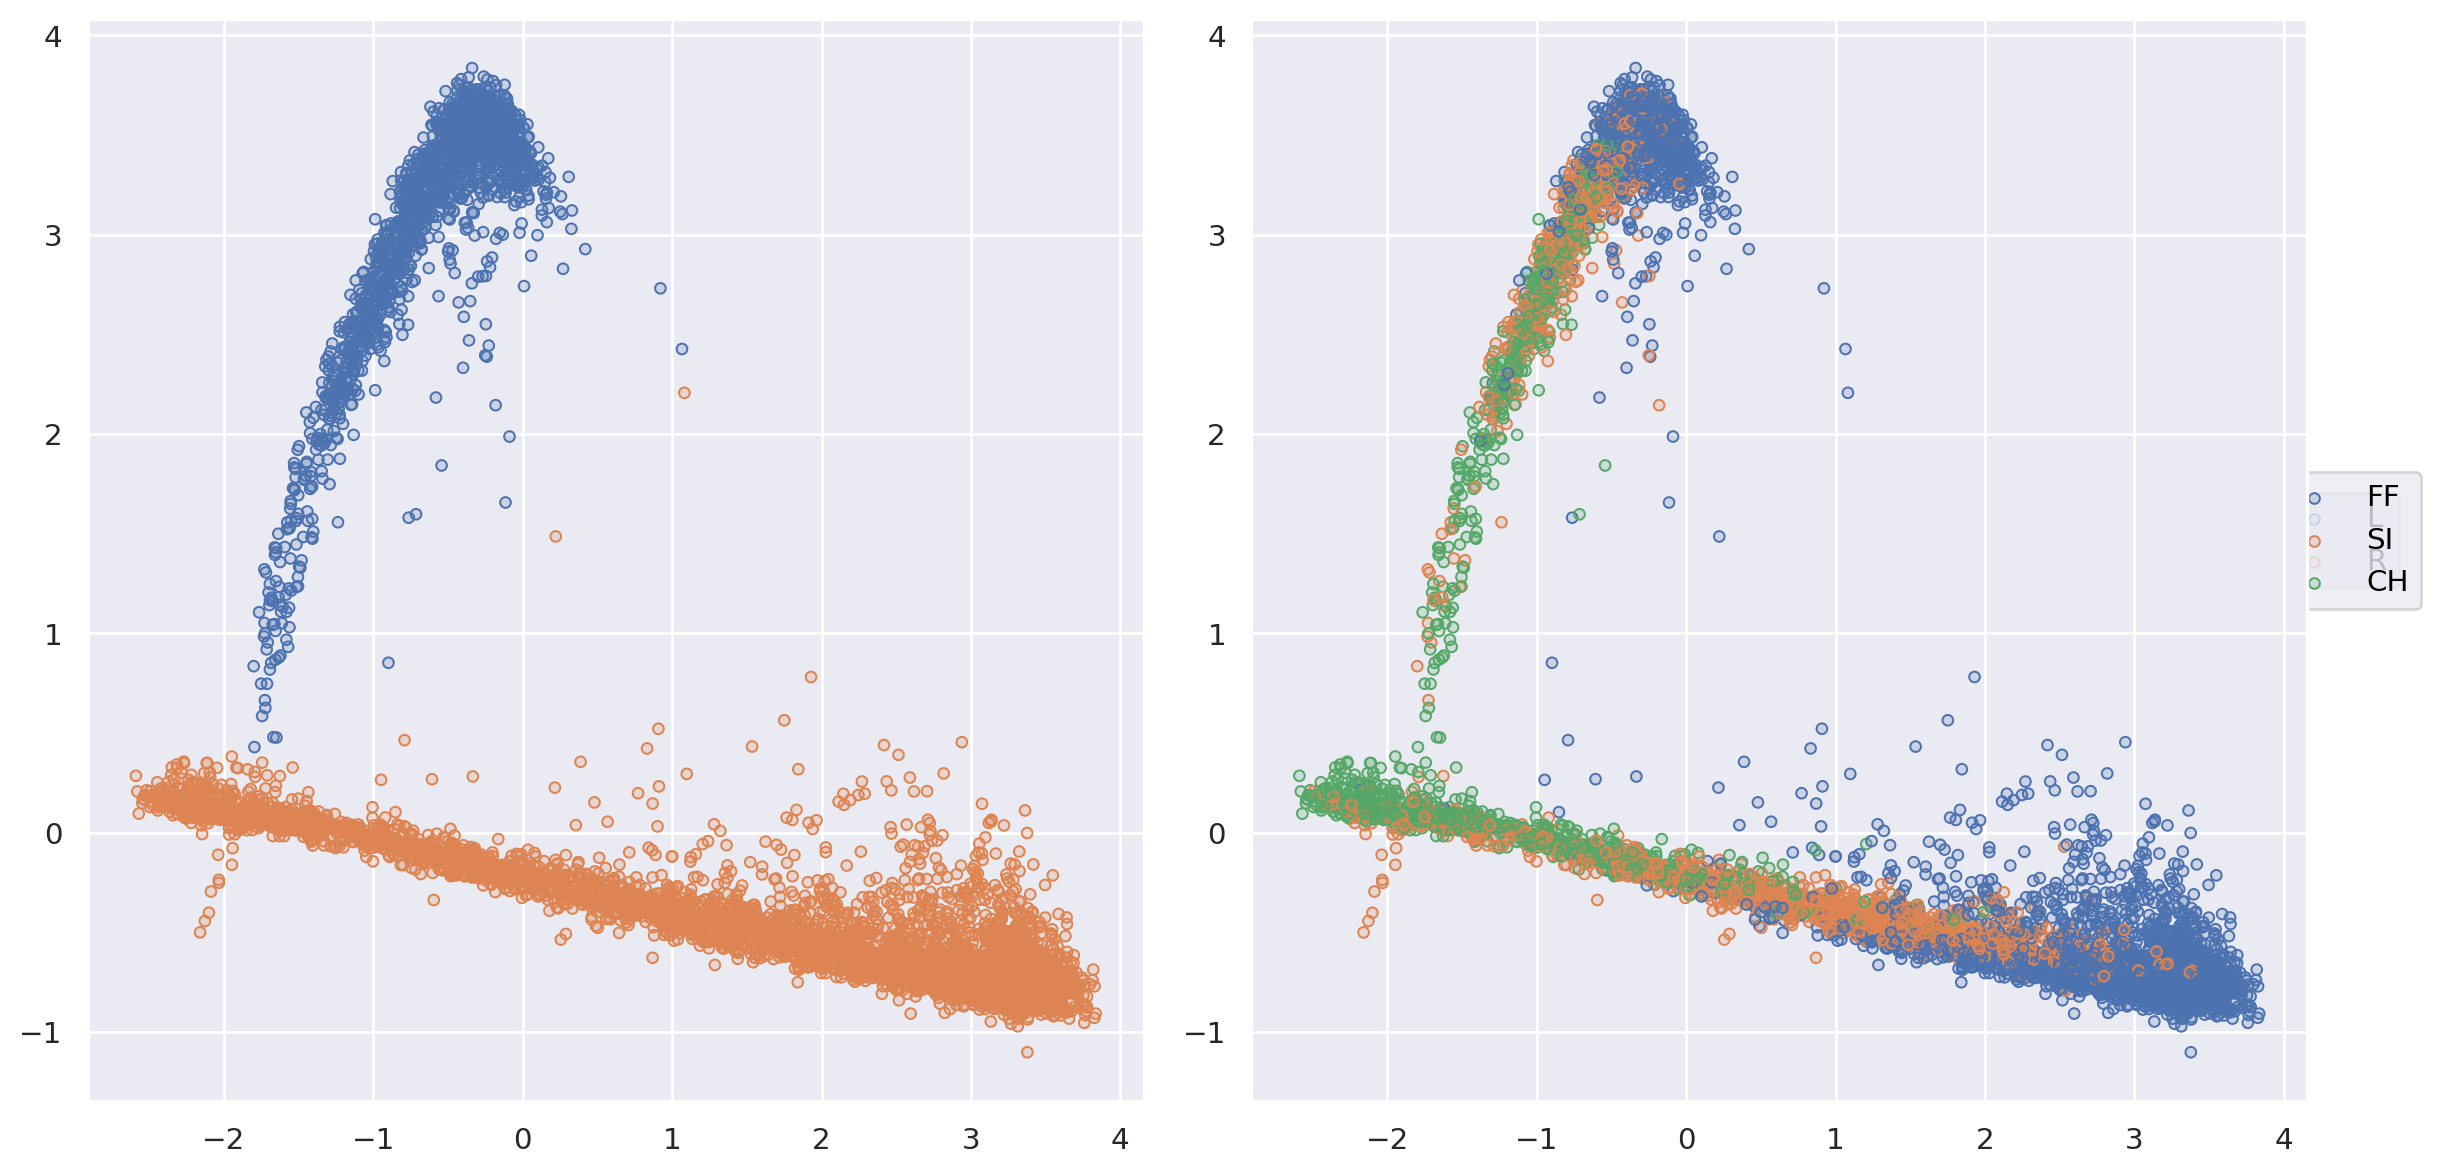

In [7]:
p_hand_plot = (
    so.Plot()
    .add(
        so.Dots(), 
        # Just look at the first two PCs
        x=pcs_limited[cf, 0], 
        y=pcs_limited[cf, 1], 
        color=pt_readable[cf]
    )
)
pitch_type_plot = (
    so.Plot()
    .add(
        so.Dots(),
        x=pcs_limited[cf, 0], 
        y=pcs_limited[cf, 1], 
        color=pitch_types[cf],
    )
)

f = mpl.figure.Figure(figsize=(12, 6), dpi=300, layout="constrained")
sf1, sf2 = f.subfigures(1, 2)
p_hand_plot.on(sf1).plot()
pitch_type_plot.on(sf2)

### Now let's go dumb and use t-SNE.

In [8]:
pitch_types = targets["pitch_type"].to_numpy()[:10_000]
p_throws = targets["p_throws"].to_numpy()[:10_000]
pt_readable = np.where(p_throws == 0, "L", "R")

# Four-seam, sinker, changeup
fastball_filter = np.isin(pitch_types, ["FF", "SI", "CH"])
# Curve, slider, sweeper, cut fastball 
breaking_filter = np.isin(pitch_types, ["CU", "SL", "ST", "FC"])

cf = fastball_filter

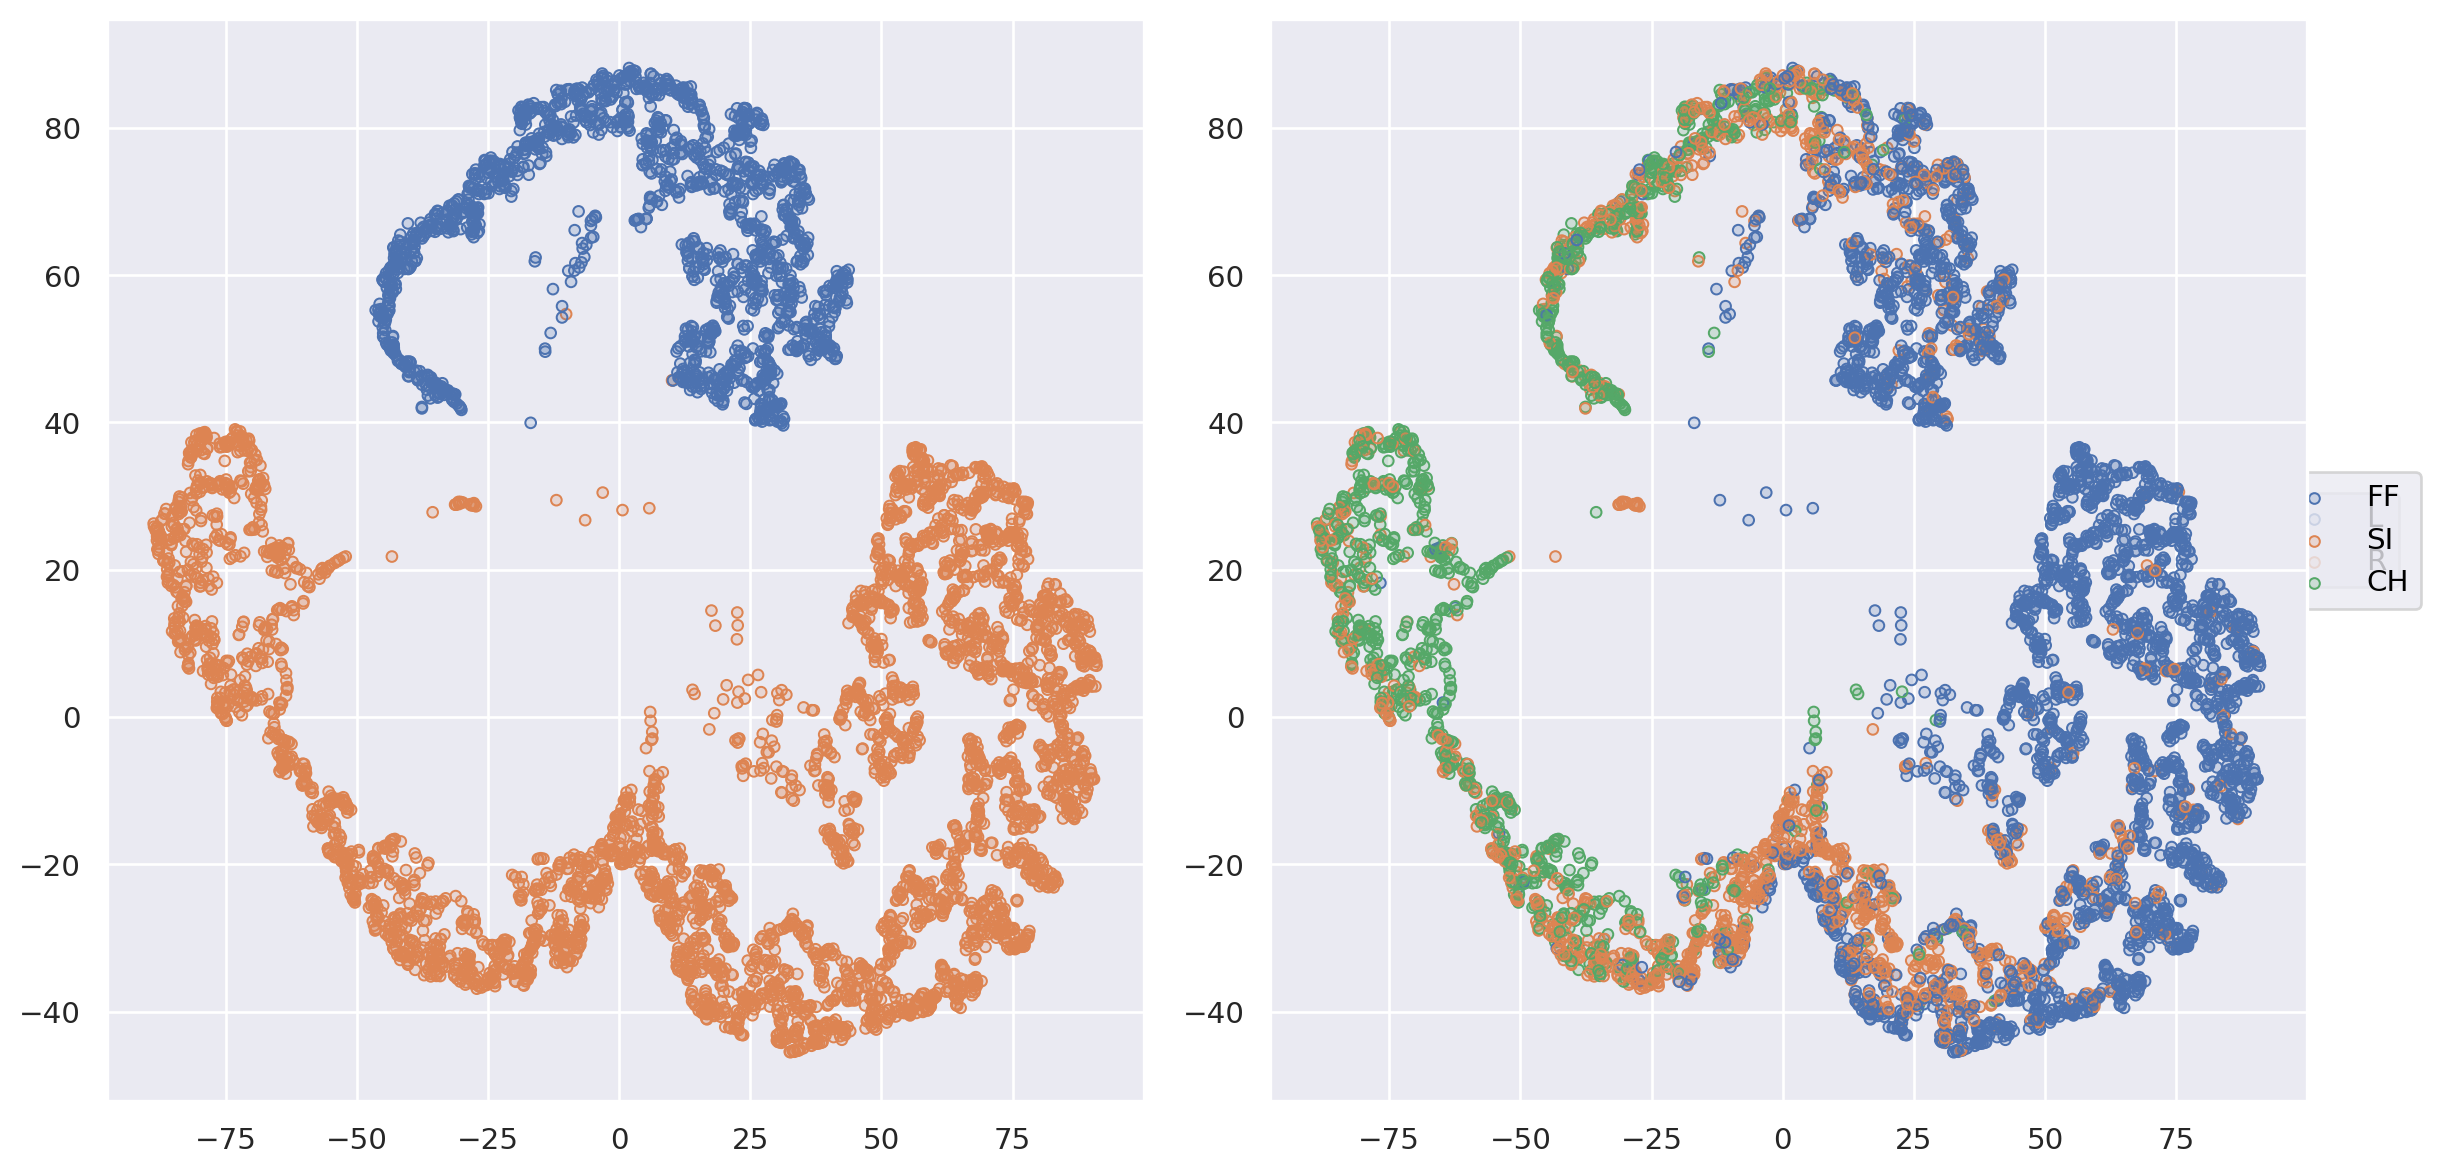

In [9]:
p_hand_plot = (
    so.Plot()
    .add(
        so.Dots(), 
        x=tsne_embeddings[cf, 0], 
        y=tsne_embeddings[cf, 1], 
        color=pt_readable[cf]
    )
)
pitch_type_plot = (
    so.Plot()
    .add(
        so.Dots(),
        x=tsne_embeddings[cf, 0], 
        y=tsne_embeddings[cf, 1], 
        color=pitch_types[cf],
    )
)

f = mpl.figure.Figure(figsize=(12, 6), dpi=300, layout="constrained")
sf1, sf2 = f.subfigures(1, 2)
p_hand_plot.on(sf1).plot()
pitch_type_plot.on(sf2)